# Airbnb in Lisbon

For city X, I want to know:
* avg price
* Most expensive month 
* Least expensive month
* Busiest month(occ rate)
* Less busiest month
* Avg rating per neighborhood
* Best neighborhood
* Most popular neighoborhood
* Most expensive neighborhood
* Least expensive neighborhood
* Neighborhood summary
* Best listing at neighborhood X
* Quietest neighborhood
* Safest neighborhood
* Most touristy neighborhood
* Neighborhood word cloud
* Listing keywords
* find avg Price according vs room's type
* find avg Price according vs neighborhood and how many booked there
* plot reviews vs prices
* plot reviews vs overall satisfaction
* plot overall satisfaction vs price



# Import Packages

In [200]:
import pandas as pd
import pandas_profiling
import datetime as dt
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap, FastMarkerCluster

%matplotlib inline

# Data Source

In [237]:
#data from insideairbnb.com
reviews = '/Users/nonoumasy/Google Drive/Colab Notebooks/airbnb_lisbon/reviews.csv'
listings = '/Users/nonoumasy/Google Drive/Colab Notebooks/airbnb_lisbon/listings.csv'
cal = '/Users/nonoumasy/Google Drive/Colab Notebooks/airbnb_lisbon/calendar.csv'

listings_df = pd.read_csv(listings)
reviews_df = pd.read_csv(reviews)
cal_df = pd.read_csv(cal)

#merge both dataframes
df = pd.read_csv(listings)

#change date to datetime object
reviews_df.date = pd.to_datetime(reviews_df.date)
reviews_df.set_index('date', inplace=True,)
reviews_df.sort_index(inplace=True)


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocess Data

In [4]:
#quick check to see which neighborhood column to use. Looks like neighborhood_cleansed is best
df[['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']].head()

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,Belém,Belm,Lisboa
1,Alfama,Santa Maria Maior,Lisboa
2,NaN,Aveiras de Cima,Azambuja
3,São João de Deus,Areeiro,Lisboa
4,Alfama,Santa Maria Maior,Lisboa


In [229]:
#keep only relevant variables
df = df[['id',
         'name',
         'summary',
         'space',
         'description',
         'neighborhood_overview',
         'notes',
         'transit',
         'neighbourhood_cleansed',
         'latitude',
         'longitude',
         'property_type',
         'room_type',
         'price',
         'availability_30',
         'review_scores_rating',
         'review_scores_accuracy',
         'review_scores_location',
         'review_scores_value'
]]


#reduce neighborhoods
lis_neigh = ['Santa Maria Maior',
                'Misericrdia',
                'Estrela',
                'Alcntara',
                'Belm',
                'Ajuda',
                'Campo de Ourique',
                'Santo Antnio',
                'Arroios',
                'So Vicente',
                'Penha de Frana',
                'Beato',
                'Marvila',
                'Areeiro',
                'Alvalade',
                'Avenidas Novas',
                'Campolide',
                'So Domingos de Benfica',
                'Benfica',
                'Carnide',
                'Lumiar',
                'Olivais',
                'Parque das Naes',
                'Santa Clara']

df = df[df.neighbourhood_cleansed.isin(lis_neigh)]


#remove symbols from price and cast it to float
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df.price)

In [230]:
cal_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,224040,2019-06-26,f,$55.00,$55.00,3.0,5.0
1,138087,2019-06-27,f,$100.00,$100.00,2.0,30.0
2,138087,2019-06-28,f,$100.00,$100.00,2.0,30.0
3,138087,2019-06-29,t,$100.00,$100.00,2.0,30.0
4,138087,2019-06-30,t,$100.00,$100.00,2.0,30.0


In [231]:
#Percent of listings available, t=True , f=False
cal_df.available.value_counts(normalize=True)*100

t    58.690489
f    41.309511
Name: available, dtype: float64

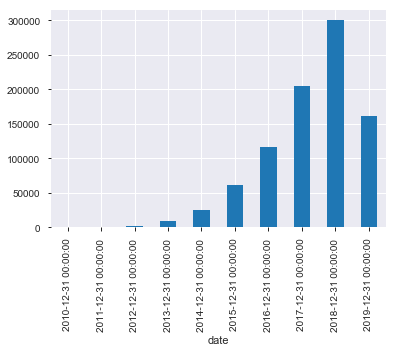

In [232]:
reviews_df.resample('A').id.count().plot(kind='bar')


In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17713 entries, 0 to 24422
Data columns (total 15 columns):
id                        17713 non-null int64
name                      17692 non-null object
summary                   17108 non-null object
space                     14194 non-null object
description               17597 non-null object
neighborhood_overview     12337 non-null object
notes                     9504 non-null object
transit                   12265 non-null object
neighbourhood_cleansed    17713 non-null object
latitude                  17713 non-null float64
longitude                 17713 non-null float64
property_type             17713 non-null object
room_type                 17713 non-null object
price                     17713 non-null float64
availability_30           17713 non-null int64
dtypes: float64(3), int64(2), object(10)
memory usage: 2.2+ MB


# Summary Statistics

In [216]:
#summary stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,17713.0,1.947883e+07,1.017894e+07,6499.00000,1.188672e+07,2.040275e+07,2.781003e+07,3.610239e+07
latitude,17713.0,3.872114e+01,1.547649e-02,38.69211,3.871132e+01,3.871606e+01,3.872691e+01,3.879435e+01
longitude,17713.0,-9.143319e+00,1.847324e-02,-9.22656,-9.150560e+00,-9.141410e+00,-9.132510e+00,-9.091230e+00
price,17713.0,9.126184e+01,1.254586e+02,0.00000,4.800000e+01,6.600000e+01,9.800000e+01,3.500000e+03
availability_30,17713.0,9.341670e+00,8.723968e+00,0.00000,2.000000e+00,7.000000e+00,1.500000e+01,3.000000e+01


In [12]:
#Number of listings in Lisbon
print('Number of Lisbon listings ', listings.shape[0])

#Number of reviews in Lisbon listings
print('Number of Reviews in Lisbon listings ', reviews.shape[0])

Number of Lisbon listings  24423
Number of Reviews in Lisbon listings  881184


In [13]:
#What is the average price per night in dollars?
df.price.mean()

96.27195676206854

# EDA

# Neighborhoods - Let's get to know the area

In [234]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 881184 entries, 2010-07-24 to 2019-06-26
Data columns (total 5 columns):
listing_id       881184 non-null int64
id               881184 non-null int64
reviewer_id      881184 non-null int64
reviewer_name    881184 non-null object
comments         880925 non-null object
dtypes: int64(3), object(2)
memory usage: 40.3+ MB


In [217]:
#Room type
df.groupby('room_type').id.count()

room_type
Entire home/apt    13257
Private room        4209
Shared room          247
Name: id, dtype: int64

In [219]:
#Number of Lisbon neighborhoods
df.neighbourhood_cleansed.nunique()

24

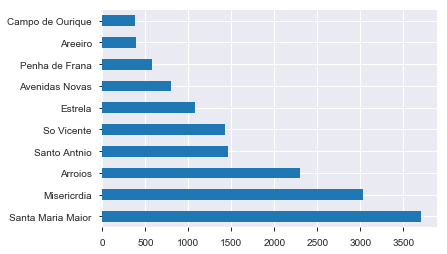

In [218]:
#Lisbon neighborhoods by listings count
df.neighbourhood_cleansed.value_counts()[:10].plot(kind='barh')

# Listings

In [114]:
#avg price by room type
df.groupby('room_type').price.mean()

room_type
Entire home/apt    105.180252
Private room        73.031722
Shared room         42.916268
Name: price, dtype: float64

In [19]:
df.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,neighbourhood_cleansed,latitude,...,room_type,square_feet,price,weekly_price,monthly_price,square_feet,availability_30,review_scores_rating,review_scores_location,comments
0,6499.0,Belém 1 Bedroom Historical Apartment,"This apartment is all about Location, next to ...",Fully furnished apartment (35m2). Small inside...,"This apartment is all about Location, next to ...","To get to the city center, tram 15 stops in f...",Late check in's (after 20H) have an extra char...,The apartment is on the same street as the #15...,Belm,38.69675,...,Entire home/apt,377.0,36.0,$209.00,$579.00,377.0,5.0,98.0,10.0,"Ola Bruno,\r\n\r\nTive um mes Fantástico em se..."
1,25659.0,"Sunny, Alfama Sleeps 3 - Coeur d'Alfama",Heart of Alfama! Center of Lisbon. Sunny Char...,Charming sunny apartment in the heart of Alfam...,Heart of Alfama! Center of Lisbon. Sunny Char...,Alfama is the oldest and most picturesque quar...,Check in after 3 PM although we try to accommo...,The apartment is very convenient to all kinds ...,Santa Maria Maior,38.71167,...,Entire home/apt,NaN,60.0,$350.00,NaN,NaN,5.0,96.0,10.0,Encontramos o apartamento de Bruno exatamente ...
2,28066.0,ear the birds,NaN,traditional farm house in a quiet place where ...,traditional farm house in a quiet place where ...,NaN,NaN,NaN,Aveiras de Cima,39.14654,...,Private room,NaN,53.0,NaN,NaN,NaN,30.0,NaN,NaN,Estivemos em Lisboa por aproximadamente 03 (tr...
3,29138.0,Room for rent in shared house,NaN,"05 minutes from city center by subway, 10 minu...","05 minutes from city center by subway, 10 minu...",NaN,NaN,NaN,Areeiro,38.73634,...,Private room,NaN,71.0,NaN,NaN,NaN,30.0,NaN,NaN,Superbe quartier très proche du tram et du tra...
4,29248.0,Apartamento Alfama com vista para o rio!,NaN,"Located in the city center, and great location...","Located in the city center, and great location...",NaN,NaN,NaN,Santa Maria Maior,38.71272,...,Entire home/apt,NaN,60.0,$299.00,$966.00,NaN,4.0,91.0,10.0,"Très bel appartement, bien situé et à proximit..."


In [20]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

%matplotlib inline

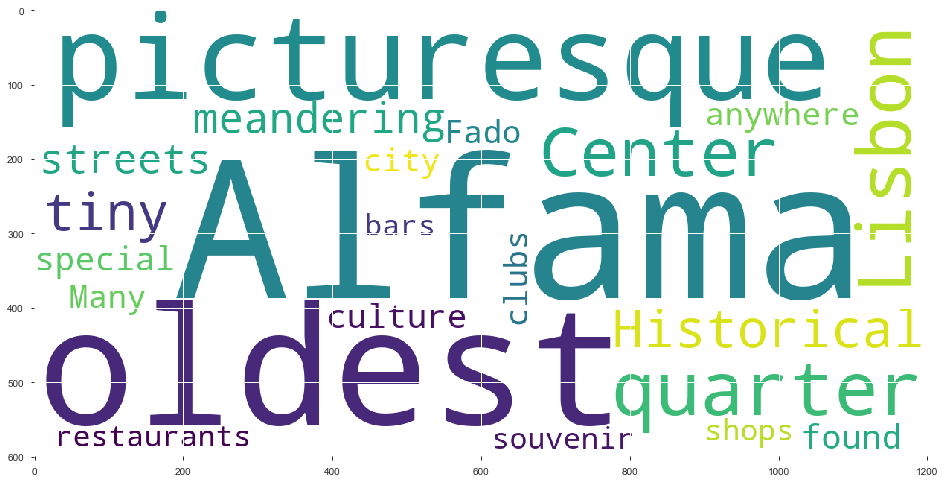

In [21]:
wc = WordCloud(width=1200, height=600, background_color='white', colormap='viridis').generate(df.neighborhood_overview[1])
plt.figure(figsize=(16,9))
plt.imshow(wc)
plt.show()

In [117]:
# Function that returns number of words in a string
def count_words(string):
    # Split the string into words
    words = string.split()
    
    # Return the number of words
    return len(words)

# Create a new feature word_count
df['word_count'] = df['neighborhood_overview'].apply(count_words)

# Print the average word count of the talks
print(df['word_count'].sum())
print(df['word_count'].mean())

AttributeError: 'float' object has no attribute 'split'

In [138]:
from textblob import TextBlob

TextBlob(df.comments[1]).sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [38]:
df.comments[1]

'Encontramos o apartamento de Bruno exatamente conforme a descrição e as fotos, além de muito bem limpo, cuidado com muito carinho e equipado com tudo o que é necessário e prático. Lençóis e toalhas disponíveis, travesseiros e uma cama extremamente confortável. A localização é incrível, segura e perfeita para visitar Lisboa. Todos os monumentos e locais históricos de Belém estão a alguns minutos da caminhada mais agradável da cidade, em meio a jardins, praças e restaurantes, e muitas opções de transportes para as outras zonas estão à porta do prédio. Numa estada mais extensa, como a nossa, é importante que o anfitrião esteja sempre ao alcance, e a atenção e a disponibilidade de Bruno realmente impressionam. Nenhuma de nossas comunicações e nenhum pequeno ajuste ou providência que foi necessária demorou mais do que alguns minutos. Uma de nossas melhores experiências no AirBnb.'

Text(0, 0.5, 'Neighborhood')

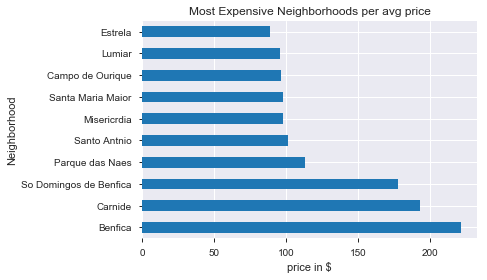

In [223]:
#Most Expensive Neighborhoods per avg price
df.groupby('neighbourhood_cleansed').price.mean().sort_values(ascending=False)[:10].plot(kind='barh')
plt.title('Most Expensive Neighborhoods per avg price')
plt.xlabel('price in $')
plt.ylabel('Neighborhood')

Text(0, 0.5, 'Neighborhood')

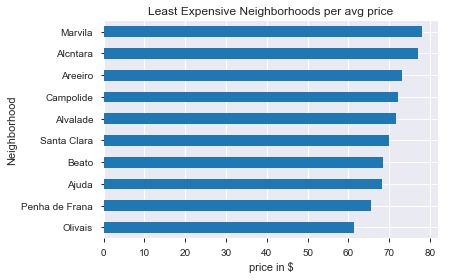

In [222]:
#Least Expensive Neighborhoods per avg price
df.groupby('neighbourhood_cleansed').price.mean().sort_values()[:10].plot(kind='barh')
plt.title('Least Expensive Neighborhoods per avg price')
plt.xlabel('price in $')
plt.ylabel('Neighborhood')

# Map

In [220]:

geolocator = Nominatim(user_agent="airbnb_lisbon")
lis = geolocator.geocode('Lisbon')
lis_loc = (loc.latitude, loc.longitude)

loc_list = df[['latitude', 'longitude']].values.tolist()
m = folium.Map(lis_loc, zoom_start=12, tiles='StamenWatercolor')
folium.plugins.Fullscreen(position='bottomright').add_to(m)
FastMarkerCluster(loc_list).add_to(m)
HeatMap(loc_list, min_opacity=0.3).add_to(m)

m



# Key Findings(Insights)

* Most Expensive Neighborhood: Benfica
* Least Expensive Neighbordhood: Olvais
* Current Availability: 59%
* Avg rating per neighborhood: 
